![logo](http://i.imgur.com/7s3jqZM.png)
# Implementing BTYD in Python *(using lifetimes)* 

Hello,this notebook is an introduction to BTYD (Buy Till You Die) model implementation in python using the ["lifetimes" package](https://pypi.python.org/pypi/Lifetimes).

## Introduction

Lifetimes can be used to analyze your users based on a few assumption:

1. Users interact with you when they are "alive".
2. Users under study may "die" after some period of time.

I've quoted "alive" and "die" as these are the most abstract terms: feel free to use your own defintion of "alive" and "die" (they are used similarly to "birth" and "death" in survival analysis). Whenever we have individuals repeating occurrences, we can use Lifetimes to help understand user behaviour.

### Applications

If this is too abstract, consider these applications:

- Predicting how often a visitor will return to your website. (Alive = visiting. Die = decided the website wasn't for them)
- Understanding how frequently a patient may return to a hospital. (Alive = visiting. Die = maybe the patient moved to a new city, or became deceased.)
- Predicting individuals who have churned from an app using only their usage history. (Alive = logins. Die = removed the app)
- Predicting repeat purchases from a customer. (Alive = actively purchasing. Die = became disinterested with your product)
- Predicting the lifetime values of your customers

### Specific Application: Customer Lifetime Value
As emphasized by P. Fader and B. Hardie, understanding and acting on customer lifetime value (CLV) is the most important part of your business's sales efforts. [And (apparently) everyone is doing it wrong](https://www.youtube.com/watch?v=guj2gVEEx4s) *Lifetimes* is a Python library to calculate CLV for you.

## Quickstart

For the following examples, we'll use a dataset from an ecommerce provider to analyze their customers' repeat purchases. The examples below are using the `cdnow_customers.csv` located in the `datasets/` directory.

In [1]:
#import the dataset
from lifetimes.datasets import load_cdnow

In [2]:
#give it a reasonable name
data = load_cdnow()

In [3]:
#view the first 5 observations in your data
data.head()

,ID,frequency,recency,T
0,1,2,30.43,38.86
1,2,1,1.71,38.86
2,3,0,0.00,38.86
3,4,0,0.00,38.86
4,5,0,0.00,38.86


#### What do these columns represent?

- `frequency` represents the number of *repeat* purchases the customer has made. This means that it's one less than the total number of purchases. 
- `T` represents the age of the customer in whatever time units chosen (weekly above). This is equal to the duration between a customer's first purchase and the end of the period under study.
- `recency` represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer's first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

If your data is not in the format (very common), there are [utility functions](#example-using-transactional-datasets) in lifetimes to transform your data to look like this.

#### Fitting models to our data

We'll use the **BG/NBD model** first. Interested in the model? See this [nice paper here](http://mktg.uni-svishtov.bg/ivm/resources/Counting_Your_Customers.pdf)


In [4]:
#import the model, which we will use for predictions
from lifetimes import BetaGeoFitter

In [5]:
#give the model a reasonable name
bgf = BetaGeoFitter()
#fit the model to your data
bgf.fit(data['frequency'], data['recency'], data['T'])

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>

After fitting, we have lots of nice methods and properties attached to the fitter object.

#### Visualizing our Frequency/Recency Matrix
Consider: a customer bought from you every day for three weeks straight, and we haven't heard from them in months. What are the chances they are still "alive"? Pretty small. On the other hand, a customer who historically buys from you once a quarter, and bought last quarter, is likely still alive. We can visualize this relationship using the **Frequency/Recency matrix**, which computes the expected number of transactions an artifical customer is to make in the next time period, given his or her recency (age at last purchase) and frequency (the number of repeat transactions he or she has made).

To plot the **Frequency/Recency matrix** we need to also import the matplotlib.pyplot module.
To show the plot inline (on the same page) we use the "%matplotlibe inline" command.

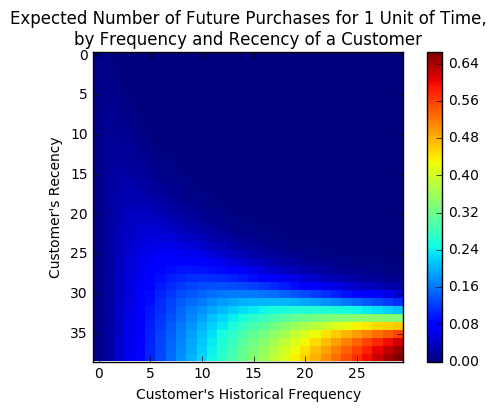

In [6]:
#import the python library necessary for plotting
import matplotlib.pyplot as plt
#show plots inline, below the code
%matplotlib inline

#import the plotting function
from lifetimes.plotting import plot_frequency_recency_matrix
#plot
plot_frequency_recency_matrix(bgf)

We can see that if a customer has bought 25 times from you, and their lastest purchase was when they were 35 weeks old (given the individual is 35 weeks old), then they are your best customer (bottom-right). Your coldest customers are those that are in the top-right corner: they bought a lot quickly, and we haven't seen them in weeks.

There's also that beautiful "tail" around (5,25). That represents the customer who buys infrequently, but we've seen him or her recently, so they *might* buy again - we're not sure if they are dead or just between purchases.

Another interesting matrix to look at is the probability of still being *alive*:

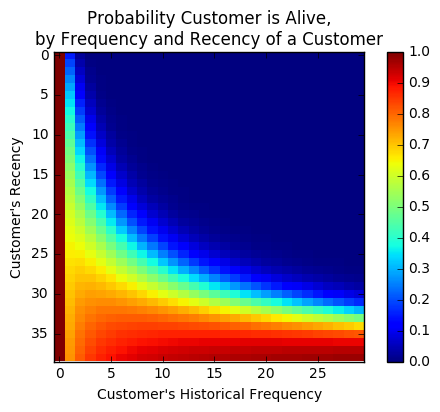

In [7]:
#import the plotting function
from lifetimes.plotting import plot_probability_alive_matrix
#plot
plot_probability_alive_matrix(bgf)

#### Ranking customers from best to worst

Let's return to our customers and rank them from "highest expected purchases in the next period" to lowest. Models expose a method that will predict a customer's expected purchases in the next period using their history.

In [8]:
#put t=1, to predict for the next period. Prediction for next 2 periods would use t=2 etc.
t = 1

#create new column in your dataframe and save there predictions
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t, data['frequency'], data['recency'], data['T']
)

In [9]:
#sort your dataframe by predictions (increasing order)
data.sort_values(by='predicted_purchases').tail(10)

,ID,frequency,recency,T,predicted_purchases
1016,1017,12,32.43,33.43,0.296308
692,693,13,34.43,35.00,0.312249
812,813,13,33.86,34.29,0.318802
1412,1413,14,30.29,31.57,0.360929
1538,1539,14,29.86,30.86,0.371088
508,509,18,35.14,35.86,0.424878
840,841,19,34.00,34.14,0.474739
1980,1981,17,28.43,28.86,0.486526
156,157,29,37.71,38.00,0.662397
1515,1516,26,30.86,31.00,0.710624


Great, we can see that the customer who has made 26 purchases, and bought very recently from us, is probably going to buy again in the next period.

#### Assessing model fit

Ok, we can predict and we can visualize our customers' behaviour, but is our model correct? There are a few ways to assess the model's correctness. The first is to compare your data versus artifical data simulated with your fitted model's parameters.

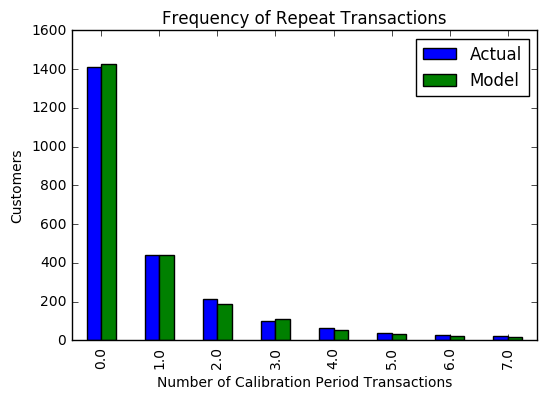

In [10]:
#import the plot function
from lifetimes.plotting import plot_period_transactions
#plot
plot_period_transactions(bgf)

We can see that our actual data and our simulated data line up well. This proves that our model works well.

![img](https://www.citrix.com/blogs/wp-content/uploads/2010/01/you-decide001.jpg)
### Part below was not performed in the classroom. Reading it is optional, but you are highly encouraged to do so.

### Estimating Customers' Lifetime Value  
For this whole time we didn't take into account the economic value of each transaction and we focused mainly on
transactions' occurrences. To estimate this we can use the Gamma-Gamma submodel. But first we need to create summary data
from transactional data also containing economic values for each transaction (i.e. profits or revenues).

In [11]:
#import the new dataset
from lifetimes.datasets import load_summary_data_with_monetary_value

In [12]:
#give it a reasonable name
CLV_data = load_summary_data_with_monetary_value()
#view the first 5 observations
CLV_data.head()

,frequency,recency,T,monetary_value
customer_id,,,,
1,2,30.43,38.86,22.35
2,1,1.71,38.86,11.77
3,0,0.00,38.86,0.00
4,0,0.00,38.86,0.00
5,0,0.00,38.86,0.00


In [14]:
#choose only RETURNING customers
returning = CLV_data[CLV_data['frequency']>0]
#view the first 5 observatinos
returning.head()

,frequency,recency,T,monetary_value
customer_id,,,,
1,2,30.43,38.86,22.35
2,1,1.71,38.86,11.77
6,7,29.43,38.86,73.74
7,1,5.00,38.86,11.77
9,2,35.71,38.86,25.55


In [15]:
#import the model which we will use for predictions
from lifetimes import GammaGammaFitter
#give it a reasonable name
ggf = GammaGammaFitter()

#fit the model to your data
ggf.fit(returning['frequency'], returning['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>

We can now estimate the average transaction value:

In [16]:
#calculate average trasaction value
average_tr_value = ggf.conditional_expected_average_profit(CLV_data['frequency'], CLV_data['monetary_value'])
#view first 5 observations
average_tr_value.head()

customer_id
1    24.658614
2    18.911474
3    35.171012
4    35.171012
5    35.171012
dtype: float64

# THE END